# Convolutions in language modeling

In [1]:
import numpy as np
import pandas as pd
from abc import ABC, abstractmethod
import copy

import matplotlib.pyplot as plt

from typing import Union
from IPython.display import HTML, clear_output
np.random.seed(42)

In [34]:
BOS, EOS = ' ', '\n'

data = pd.read_json("./data/arxivData.json")
lines = data.apply(lambda row: (row['title'] + ' ; ' + row['summary'])[:128], axis=1) \
            .apply(lambda line: BOS + line.replace(EOS, ' ') + EOS) \
            .tolist()

In [35]:
tokens = list(set(''.join(lines)))

num_tokens = len(tokens)
print('num_tokens = ', num_tokens)

num_tokens =  136


In [36]:
token_to_id = {token: idx for idx, token in enumerate(tokens)}
token_to_id

{'a': 0,
 'n': 1,
 'm': 2,
 'o': 3,
 '-': 4,
 'D': 5,
 '@': 6,
 '~': 7,
 '\\': 8,
 '\x7f': 9,
 'r': 10,
 'τ': 11,
 'Y': 12,
 'β': 13,
 '?': 14,
 '4': 15,
 'é': 16,
 'b': 17,
 'χ': 18,
 'B': 19,
 'q': 20,
 'H': 21,
 ':': 22,
 'Ł': 23,
 'u': 24,
 'σ': 25,
 'ő': 26,
 'ö': 27,
 'I': 28,
 'ś': 29,
 'L': 30,
 ']': 31,
 'ã': 32,
 '|': 33,
 'ç': 34,
 ',': 35,
 'G': 36,
 'α': 37,
 '^': 38,
 '°': 39,
 '{': 40,
 '$': 41,
 'ä': 42,
 'w': 43,
 ' ': 44,
 'μ': 45,
 'Σ': 46,
 "'": 47,
 'F': 48,
 'y': 49,
 'h': 50,
 'N': 51,
 '5': 52,
 'à': 53,
 'P': 54,
 'p': 55,
 'O': 56,
 'J': 57,
 's': 58,
 '>': 59,
 ';': 60,
 'Z': 61,
 'l': 62,
 'R': 63,
 'Q': 64,
 'T': 65,
 '1': 66,
 '7': 67,
 'ω': 68,
 '\n': 69,
 'λ': 70,
 'ν': 71,
 'γ': 72,
 'g': 73,
 'k': 74,
 '#': 75,
 'ô': 76,
 'C': 77,
 'c': 78,
 '*': 79,
 '=': 80,
 'j': 81,
 '6': 82,
 '<': 83,
 'â': 84,
 'W': 85,
 '_': 86,
 'A': 87,
 'i': 88,
 'Ö': 89,
 'æ': 90,
 '(': 91,
 't': 92,
 '9': 93,
 'í': 94,
 'Ω': 95,
 'v': 96,
 'S': 97,
 'f': 98,
 'E': 99,
 '"':

In [37]:
def to_matrix(data, token_to_id, max_len=None, dtype='int32', batch_first=True):
    """Casts a list of names into rnn-digestable matrix"""
    
    max_len = max_len or max(map(len, data))
    data_ix = np.zeros([len(data), max_len], dtype) + token_to_id[' ']

    for i in range(len(data)):
        line_ix = [token_to_id[c] for c in data[i]]
        data_ix[i, :len(line_ix)] = line_ix
        
    if not batch_first: # convert [batch, time] into [time, batch]
        data_ix = np.transpose(data_ix)

    return data_ix

In [38]:
MAX_LENGTH = max(map(len, lines))
sample = to_matrix(np.random.choice(lines, size=5), token_to_id, max_len=MAX_LENGTH)

In [39]:
class BaseLayer(ABC):
    @abstractmethod
    def __init__(self) -> None:
        pass

    def __call__(self, x: np.array, grad: bool = True) -> np.array:
        return self.forward(x, grad)

    @abstractmethod
    def forward(self, x: np.array, grad: bool = True) -> np.array:
        pass

    @abstractmethod
    def backward(self, output_error: np.array) -> np.array:
        pass


class Linear3d(BaseLayer):
    """
    Linear class permorms ordinary FC layer in neural networks
    Parameters:
    n_input - size of input neurons
    n_output - size of output neurons
    Methods:
    set_optimizer(optimizer) - is used for setting an optimizer for gradient descent
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate) - performs backward pass of the layer
    """

    def __init__(self, n_input: int, n_output: int) -> None:
        super().__init__()
        self.input = None
        self.n_input = n_input
        self.n_output = n_output
        self.w = np.random.normal(scale=np.sqrt(2 / (n_input + n_output)), size=(n_input, n_output))
        self.b = np.random.normal(scale=np.sqrt(2 / (n_input + n_output)), size=(1, n_output))

        self.w_optimizer = None
        self.b_optimizer = None

    def set_optimizer(self, optimizer) -> None:
        self.w_optimizer = copy.copy(optimizer)
        self.b_optimizer = copy.copy(optimizer)

        self.w_optimizer.set_weight(self.w)
        self.b_optimizer.set_weight(self.b)

    def forward(self, x: np.array, grad: bool = True) -> np.array:
        self.input = x
        return np.matmul(x, self.w) + self.b  # the same as @

    def backward(self, output_error: np.array) -> np.array:
        assert self.w_optimizer is not None and self.b_optimizer is not None, 'You should set an optimizer'
        # перемножаем последние 2 измерения друг с другом с помощью matmul и суммируем
        w_grad = np.sum(np.transpose(self.input, (0, 2, 1)) @ output_error, axis=0)
        b_grad = np.sum(output_error, axis=(0, 1))
        input_error = output_error @ self.w.T

        self.w = self.w_optimizer.step(w_grad)
        self.b = self.b_optimizer.step(b_grad)
        return input_error


class Activation(BaseLayer):
    """
    Activation class is used for activation function of the FC layer
    Params:
    activation_function - activation function (e.g. sigmoid, RElU, tanh)
    activation_derivative - derivative of the activation function
    Methods:
    forward(x) - performs forward pass of the layer
    backward(output_error, learning_rate) - performs backward pass of the layer
    """

    def __init__(self, activation_function: callable, activation_derivative: callable) -> None:
        super().__init__()
        self.input = None
        self.activation = activation_function
        self.derivative = activation_derivative

    def forward(self, x: np.array, grad: bool = True) -> np.array:
        self.input = x
        return self.activation(x)

    def backward(self, output_error: np.array) -> np.array:
        return output_error * self.derivative(self.input)

class BaseOptimizer(ABC):
    @abstractmethod
    def __init__(self) -> None:
        pass

    @abstractmethod
    def set_weight(self, weight: np.array) -> None:
        pass

    @abstractmethod
    def step(self, grad: np.array) -> np.array:
        pass

class ADAM(BaseOptimizer):
    """
    Implements Adam algorithm.

    learning_rate (float, optional) – learning rate (default: 1e-3)
    beta1, beta2 (Tuple[float, float], optional) –
    coefficients used for computing running averages of gradient and its square (default: (0.9, 0.999))
    eps (float, optional) – term added to the denominator to improve numerical stability (default: 1e-8)
    """

    def __init__(self, beta1: float = 0.9, beta2: float = 0.999, eps: float = 1e-8,
                 learning_rate: float = 3e-4, weight_decay: float = 0) -> None:
        self.beta1 = beta1
        self.beta2 = beta2
        self.eps = eps
        self.learning_rate = learning_rate
        self.weight_decay = weight_decay

        self.EMA1 = None
        self.EMA2 = None

        self.weight = None

    def set_weight(self, weight: np.array) -> None:
        self.weight = weight.copy()
        self.EMA1 = np.zeros(shape=self.weight.shape)
        self.EMA2 = np.zeros(shape=self.weight.shape)

    def step(self, grad: np.array) -> np.array:
        assert self.weight is not None, 'You should set the weight'
        grad = grad.copy() + self.weight_decay * self.weight
        self.EMA1 = (1 - self.beta1) * grad + self.beta1 * self.EMA1
        self.EMA2 = (1 - self.beta2) * grad ** 2 + self.beta2 * self.EMA2
        self.weight -= self.learning_rate * self.EMA1 / (np.sqrt(self.EMA2) + self.eps)

        return self.weight.copy()

class Embedding(BaseLayer):
    def __init__(self, n_input, emb_dim, pad_idx=None):
        self.n_input = n_input
        self.emb_dim = emb_dim
        self.pad_idx = pad_idx
        
        self.weights = np.random.normal(scale=np.sqrt(2/(n_input+emb_dim)), size=(n_input, emb_dim))

    def set_optimizer(self, optimizer):
        self.weights_optimizer = copy.copy(optimizer)

        self.weights_optimizer.set_weight(self.weights)

    def forward(self, x, grad=True):
        self.input = x
        return self.weights[x]

    def backward(self, output_error):
        weights_grad = np.zeros_like(self.weights)
        input_shape_len = len(self.input.shape)

        if input_shape_len == 2:
            for batch_n, s in enumerate(self.input):
                for i, emb_i in enumerate(s):
                    weights_grad[emb_i] += output_error[batch_n][i]

        elif input_shape_len == 1:
            for i, emb_i in enumerate(self.input):
                weights_grad[emb_i] += output_error[i]

        if self.pad_idx is not None:
            weights_grad[self.pad_idx] = 0

        self.weights = self.weights_optimizer.step(weights_grad)

In [40]:
def tanh(z: Union[np.array, float, int, list]) -> Union[np.array, float]:
    """
    Tanh function
    """
    return np.tanh(z)

def tanh_derivative(z: Union[np.array, float, int, list]) -> Union[np.array, float]:
    """
    Tanh function derivative
    """
    return 1 - np.tanh(z) ** 2

def sigmoid(z: Union[np.array, float, int, list]) -> Union[np.array, float]:
    """
    Sigmoid function
    """
    return 1 / (1 + np.exp(-z))

def sigmoid_derivative(z: Union[np.array, float, int, list]) -> Union[np.array, float]:
    """
    Sigmoid function derivative
    """
    s = 1 / (1 + np.exp(-z))
    return s * (1 - s)

def softmax(z: np.array) -> np.array:
    """
    Softmax function
    """
    return np.exp(z) / np.sum(np.exp(z), axis=1).reshape(-1, 1)

def cross_entropy_loss(y_true: np.array, a_pred: np.array) -> float:
    """
    CrossEntropyLoss for multi-classification tasks
    :param y_true: 2D vector with classes, i.e. [[0], [3], [4], [1], [2]]
    :param a_pred: scores for each class before softmax function with shape [n_samples, n_classes]
    :return: CrossEntropyLoss
    """
    lenght_y = list(range(len(y_true)))
    arg = -a_pred[lenght_y, y_true.ravel()]
    sum_exp = np.sum(np.exp(a_pred), axis=1)
    loss = np.sum(arg + np.log(sum_exp))
    return loss / len(y_true)

def cross_entropy_loss_derivative(y_true: np.array, a_pred: np.array) -> np.array:
    """
    CrossEntropyLoss derivative for multi-classification tasks
    :param y_true: 2D vector with classes, i.e. [[0], [3], [4], [1], [2]]
    :param a_pred: scores for each class before softmax function with shape [n_samples, n_classes]
    :return: np.array with shape [n_samples, n_classes] with CrossEntropyLoss derivatives for each weight
    """
    lenght_y = list(range(len(y_true)))
    sum_exp = np.sum(np.exp(a_pred), axis=1).reshape(-1, 1)
    loss = np.exp(a_pred.copy()) / sum_exp
    loss[lenght_y, y_true.ravel()] -= 1

    return loss / len(y_true)

In [41]:
class Conv1d(BaseLayer):
    """
    Сверточный слой, со страйдом 1 и без паддингов, для батча
    """
    def __init__(self, in_channels, out_channels, kernel_size):
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.kernel_size = kernel_size

        scale = np.sqrt(1/(in_channels*kernel_size))
        self.kernel = np.random.uniform(-scale, scale, size=(out_channels, in_channels, kernel_size))
        self.bias = np.random.uniform(-scale, scale, size=(out_channels))

    def set_optimizer(self, optimizer):
        self.kernel_optimizer = copy.copy(optimizer)
        self.bias_optimizer = copy.copy(optimizer)

        self.kernel_optimizer.set_weight(self.kernel)
        self.bias_optimizer.set_weight(self.bias)

    def forward(self, x, grad=True):
        """
        Работает с битчами вида [BATCH_SIZE, SENTENCE_LEN, EMB_DIM]
        """
        self.input = x
        self.batch_size = x.shape[0]
        self.input_len = x.shape[1]
        self.output_len = self.input_len - self.kernel_size + 1

        result = []

        for sentence in x:
            result.append(self._forward_for_one(sentence))

        return np.array(result)

    def _forward_for_one(self, x):
        """
        Просто свертка для 1 предложения
        """
        output = np.zeros(shape=(self.output_len, self.out_channels))

        # для каждого выходного канала и ядра, отвечающего за этот канал
        for kernel_i, ker in enumerate(self.kernel):
            # по выходной длине
            for i in range(self.output_len):
                # умножаем срез по размеру ядра на ядро и суммируем
                output[i:self.kernel_size+i, kernel_i] = self.bias[kernel_i] + np.sum(x[i:self.kernel_size+i, :] * ker.T)

        return output

    def backward(self, output_error):
        """
        Градиенты по всемy батчу
        """
        dy_dkernels = []
        dy_dbiass = []
        dy_dxs = []

        for i in range(self.batch_size):
            dy_dkernel, dy_dbias, dy_dx = self._calc_grad_for_one(output_error[i], self.input[i])
            dy_dkernels.append(dy_dkernel)
            dy_dbiass.append(dy_dbias)
            dy_dxs.append(dy_dx)

        dy_dkernels = np.sum(np.array(dy_dkernels), axis=0)  # суммируем градиенты по батчу
        dy_dbiass = np.sum(np.array(dy_dbiass), axis=0)
        dy_dxs = np.array(dy_dxs)

        self.kernel = self.kernel_optimizer.step(dy_dkernels)  # делаем шаг спуска по сумме градиентов
        self.bias = self.bias_optimizer.step(dy_dbiass)

        return dy_dxs

    def _calc_grad_for_one(self, output_error, x):
        dy_dkernel = np.zeros(shape=self.kernel.shape)
        dy_dbias = np.zeros(shape=self.bias.shape)
        dy_dx = np.zeros(shape=x.shape)

        for kernel_i, ker in enumerate(self.kernel):
            helper_k = np.zeros(shape=ker.T.shape)

            for i in range(self.output_len):
                helper_k += x[i:self.kernel_size+i, :] * output_error[i, kernel_i]
                dy_dx[i:self.kernel_size+i, :] += ker.T * output_error[i, kernel_i]

            dy_dkernel[kernel_i] = helper_k.T
            dy_dbias[kernel_i] = np.sum(output_error[:, kernel_i])

        return dy_dkernel, dy_dbias, dy_dx

In [42]:
class CNN:
    def __init__(self, n_tokens=num_tokens, emb_size=16, hid_size=64):
        self.emb = Embedding(n_tokens, emb_size)
        self.conv = Conv1d(emb_size, hid_size, kernel_size=5)

        self.padding_n = 4

        self.classifier = Linear3d(hid_size, n_tokens)

    def __call__(self, x):
        return self.forward(x)

    def set_optimizer(self, optimizer):
        self.emb.set_optimizer(optimizer)
        self.conv.set_optimizer(optimizer)
        self.classifier.set_optimizer(optimizer)

    def forward(self, x):

        # [BATCH_SIZE, SEQ_LEN, EMB_SIZE]
        x = self.emb(x)

        # [BATCH_SIZE, PADDING+SEQ_LEN, EMB_SIZE]
        x = self.padding(x, self.padding_n)  # модель не должна смотреть в будущее для задачи LM

        # [BATCH_SIZE, SEQ_LEN, CHANNELS_OUT~HID_SIZE]
        x = self.conv(x)

        # [BATCH_SIZE, SEQ_LEN, N_TOKENS]
        x = self.classifier(x)
        
        return x # output tensor should be of shape [batch_size, sequence_length, n_tokens]

    def padding(self, x, n):
        batch_size, seq_len, emb_dim = x.shape
        padded_x = np.zeros(shape=(batch_size, seq_len+n, emb_dim))
        padded_x[:, n:, :] = x
        return padded_x

    def backward(self, output_error):
        output_error = self.classifier.backward(output_error)
        output_error = self.conv.backward(output_error)

        output_error = output_error[:, self.padding_n:, :]
        self.emb.backward(output_error)

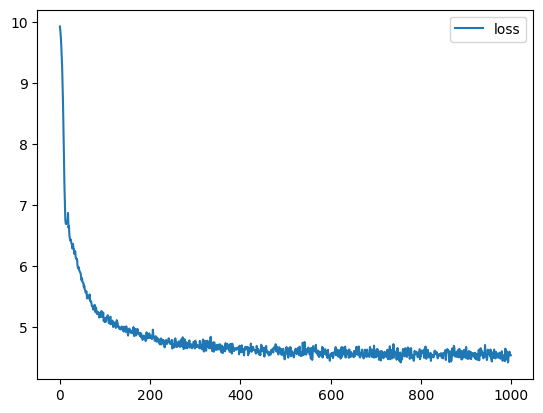

In [44]:
cnn = CNN()
cnn.set_optimizer(ADAM(learning_rate=0.001))

batch_size = 64
history = []
for i in range(1000):
    batch_ix = to_matrix(np.random.choice(lines, size=batch_size, replace=False), token_to_id, max_len=MAX_LENGTH)
    
    pred = cnn(batch_ix[:, :-1])

    loss = 0
    for t in range(batch_ix.shape[1]-1):
        loss += cross_entropy_loss(batch_ix[:, t+1].reshape(-1, 1), pred[:, t, :])
        
    errors = np.zeros(shape=(batch_size, MAX_LENGTH-1, len(token_to_id)))
    for t in range(errors.shape[1]-1):
        errors[:, t, :] = cross_entropy_loss_derivative(batch_ix[:, t+1].reshape(-1, 1), pred[:, t, :])
    
    cnn.backward(errors)
    
    # visualizing training process
    history.append(loss / batch_size)
    if (i + 1) % 10 == 0:
        clear_output(True)
        plt.plot(history,label='loss')
        plt.legend()
        plt.show()

assert np.mean(history[:10]) > np.mean(history[-10:]), "CNN didn't converge."

In [45]:
history[-1]

4.534774300998044

In [48]:
def generate_sample(char_rnn, seed_phrase=' ', max_length=MAX_LENGTH, temperature=1.0):
    phrase = copy.copy(seed_phrase)
    
    for t in range(len(seed_phrase)-1, max_length-len(seed_phrase)):
        x_sequence = to_matrix([phrase], token_to_id, max_len=max_length)

        pred = char_rnn(x_sequence)
        probs = softmax(pred[:, t] / temperature).ravel()
        next_ix = np.random.choice(len(tokens), p=probs)
        phrase += tokens[next_ix]
    return phrase

In [49]:
for _ in range(10):
    print(generate_sample(cnn, seed_phrase=' ', temperature=0.5))

 Admention ; Retication ; We pres ; We probestice s A A Senertion lation ; We pralis ; In thicy sed lation ; A Imale  Spareation t
 Aption ; We pronestion  for Fecentation ; The s and tivel ar bate Mation for Soppresing (DPercachis an dith  forecteration ation 
 Reprode tenonn (MAd) in sof che s an  of amewitity ; Tha he probly for timation ; We probaltion ; Recters of Nenworks ; We propus
 Spaperation of the roplosing bation  forme the resul  and Opalition thapes on thes for arsiticalizy nor sed ce tor bation of Cont
 Astion ; We proret inate and Sentre pored for Splestar boded on ant of A pores for Sulter ingerint andical Intren l ardementrich 
 Stement ; We presthe s al aring Apticapel ane weretive Con-bale the s the foridis  are perecting apprextine d Trestion ; The for 
 Ant en whed Modeting ; In this of enter Bandurg ; We probule Forel fre tion ation lare phosessing  fer Sens ; In thes ; Fonditima
 Fraperat Network  formang for Semprous de send Vision tha for the thas fical ures 

In [50]:
with open('./style.css') as f:
    style = f.read()
HTML(style)